# FBCM23 ToA and ToT data processing

In [177]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [178]:

matplotlib.rc('font', size=16)
def nd_dict(array):
    if type(array) == np.ndarray and not array.shape:
        return array.reshape(1)[0]
    else:
        return array
    
def process_npz(npz):
    if type(npz) != dict: # dhould compare == NpzFile:
        npz = dict(npz) 
    for k,v in npz.items():
        npz[k] = nd_dict(v)
    return npz

In [179]:
samplenum = 23
side = "R"
sample = str(samplenum) + side
file_num = 14

# 5 12 - with counter
# 5 
# data = process_npz(dict(np.load('../test_data/final_results/toa_tot_%d_%s.npz' % (sample, file_num), allow_pickle=True)))
#data = process_npz(dict(np.load('../test_data/rapid_data/toa_tot_%d_%s.npz' % (sample,file_num), allow_pickle=True)))
data = process_npz(dict(np.load('toa_tot_'+str(samplenum)+'_2_db_'+side+'.npz', allow_pickle=True, encoding="ASCII")))


results = data['toa_tot']['results']
test_conditions = data['toa_tot']['test_conditions']

twalk = data['toa_tot']['results']['twalk']


dac_8bit_maps = data['dacs_8bit']['results']['calibration']
# channel_th_offset = dac_8bit_chars['channel_th_offset']

baseline = data['noise_occ']['results']

In [180]:
# print(data['dacs_8bit']['results']['calibration']['DACTHOFFSET']['node']['TH3']['dac_map'])
# from pprint import pprint

# # del data['dacs_5bit']
# # del data['dacs_8bit']
# # del data['noise_occ']
# # del data['toa_tot']
# del data['th_scan']['results']
# print(pprint(data, depth=3))
print(data['toa_tot']['metadata'])
print(data['th_scan']['metadata'])
print(data['noise_occ']['metadata'])

{'instruments': {'scope': {'name': 'Tektronix MSO64B', 'VISA_address': 'USB0::0x0699::0x0530::C043325::INSTR', 'ProbeGain': 10}, 'pulse_generator': {'name': 'Hewlett-Packard HP81110A', 'VISA_address': 'GPIB0::10::INSTR'}, 'power_supply': {'name': 'TTi TSX1820P', 'VISA_address': 'GPIB1::3::INSTR'}, 'counter_0': {'name': 'Keithley 53220A', 'VISA_address': 'GPIB1::3::INSTR'}, 'multimeter': {'name': 'Keithley DMM7510', 'VISA_address': 'USB0::0x05E6::0x7510::04385496::INSTR'}, 'switch_0': {'name': 'CERN RFSP6T', 'VISA_address': 'TCPIP0::POOL06050001::5025::SOCKET'}, 'switch_1': {'name': 'CERN RFSP6T', 'VISA_address': 'TCPIP0::POOL06050002::5025::SOCKET'}}, 'RPi': {'COM_port': 'COM4', 'RST_pin': 10, 'SCL_pin': 7, 'SDA_pin': 6, 'TRG_pin': 1}, 'amux_read_method': 'multimeter', 'testboard_number': 23, 'temperature': 'RT', 'sensor_status': 'WS', 'test_number': '1', 'ASIC': {'CHIPID': '0x01', 'address': '0x11', 'ID': 23, 'radiation': '0'}, 'Detector': {'type': 'none'}}
{'instruments': {'scope': {

## Ploting data

In [181]:
def get_voltage(dac_map, code):
    for i in dac_map:
        if code == i['code']:
            return i['voltage']
    raise ValueError("Missing code: %s in the dac map." % code)

def tot_func(x, *args):
    eq_border = 4
    eq1 = x < eq_border
    eq2_b = args[0] + args[1]*np.sqrt(eq_border)  + args[2]*eq_border

    res = eq2_b + args[3]*(x-eq_border)
    res[eq1] = args[0] + args[1]*np.sqrt(x[eq1])  + args[2]*x[eq1] #-args[2]
    return res
    # return args[0] + args[1]*np.log(x-args[2]) + args[3]* (np.log(x-args[4]))**2

In [182]:
test_conditions['asic_channels']

[0, 2, 5]

(0.7,)
(0, 3, 6)


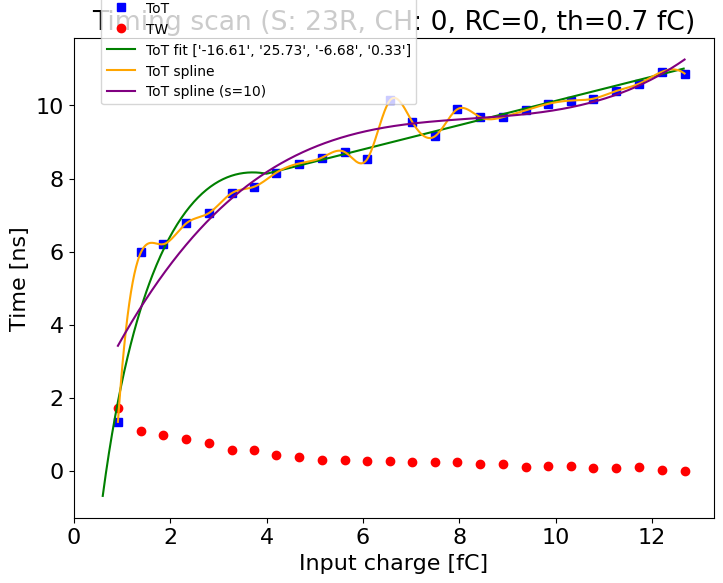

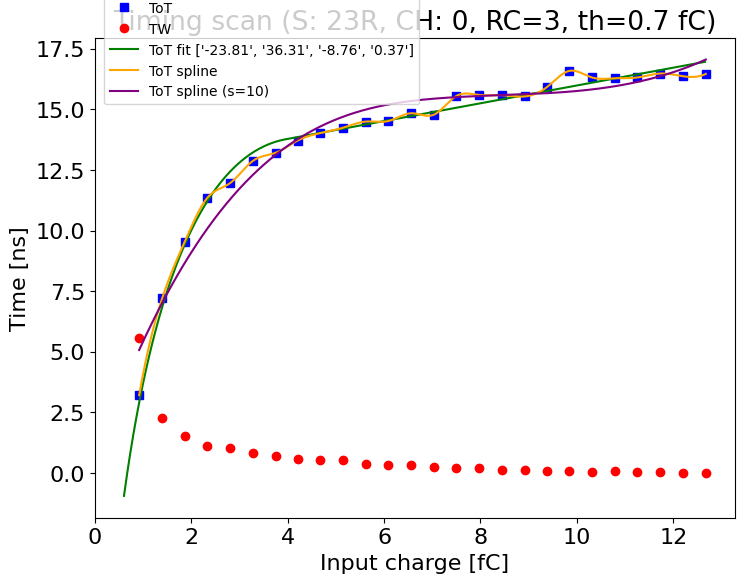

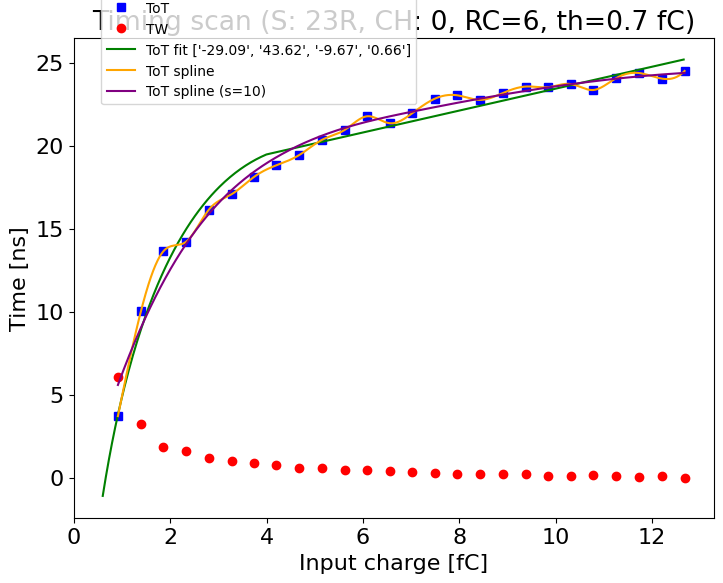

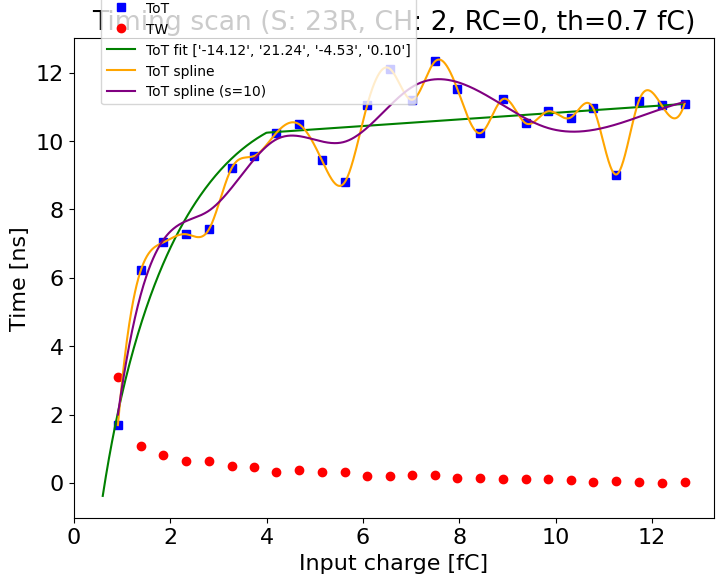

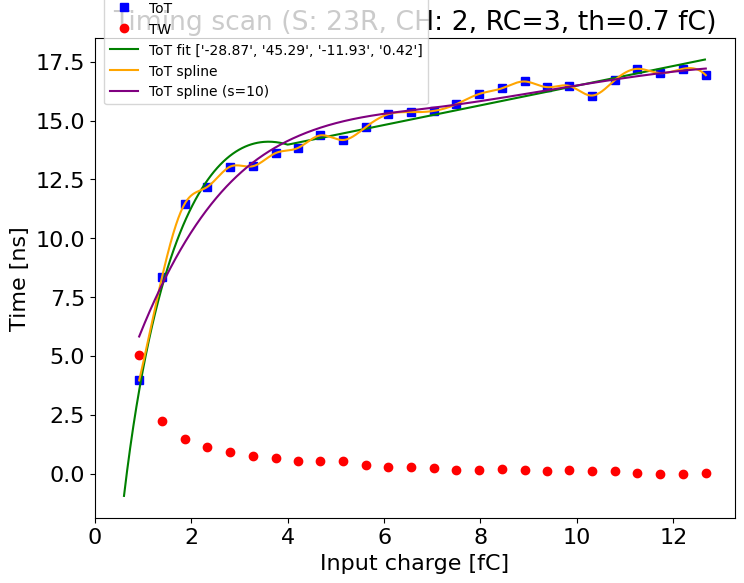

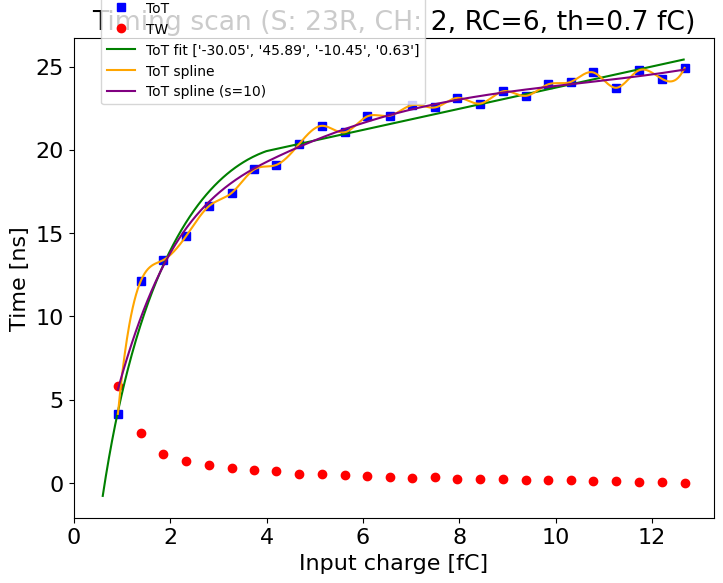

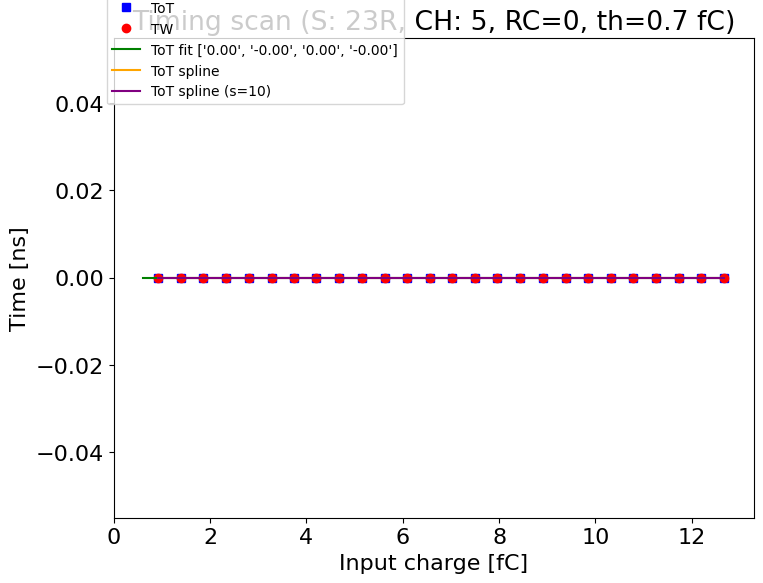

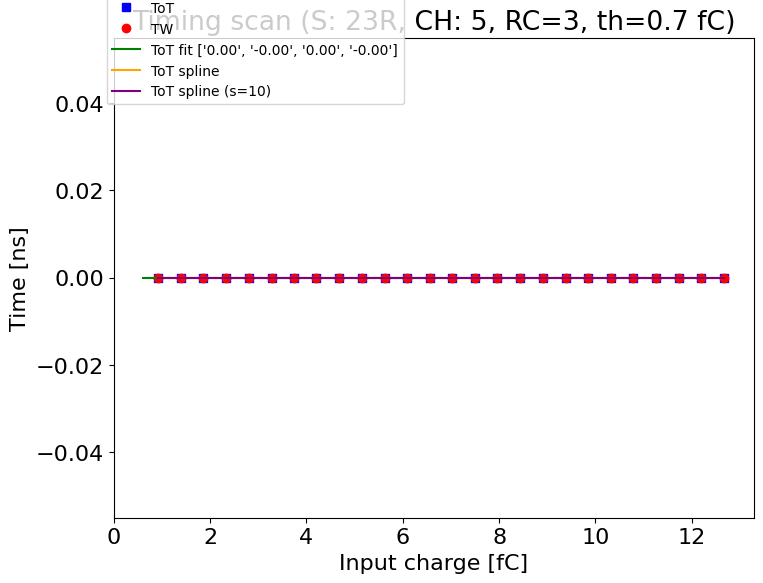

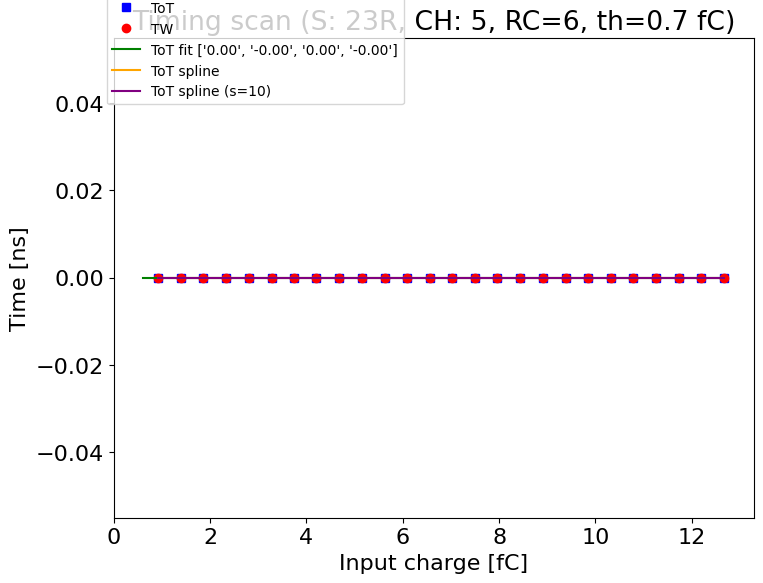

In [183]:
step = test_conditions['step']

print(test_conditions['th_list_fC'])
print(test_conditions['rccal'])
for ch_num in test_conditions['asic_channels']:

    toa = results['toa'][ch_num].copy()
    tot = results['tot'][ch_num].copy()


    tw = twalk[ch_num].copy()
    # print(tw.shape)

    # chcalval = np.zeros(shape=(256,))
    # for i in np.arange(0,256,step):
    #     chcalval[i] = get_voltage(dac_8bit_maps['CHCALVAL']['node']['CHCALVAL']['cal_char'], i)
    chcalval = dac_8bit_maps['CHCALVAL']['node']['CHCALVAL']['cal_char']

    # err = tot > 1e10
    # toa[err] = 0
    # tot[err] = 0
    for th_level_fC in range(len(test_conditions['th_list_fC'])):
        for r in range(len(test_conditions['rccal'])):
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.set_title('Timing scan (S: %s, CH: %s, RC=%x, th=%.1f fC)' % (sample, ch_num, test_conditions['rccal'][r], test_conditions['th_list_fC'][th_level_fC]))
            ax.set_ylabel('Time [ns]')
            ax.set_xlabel('Input charge [fC]')
            # start = np.argmin(err[r,0:256:step])*step # find first False what means first valid value
            if 'start' in test_conditions:
                start = test_conditions['start']
            elif 'start' in results:
                start = int(results['start'][ch_num,r,th_level_fC])
            else:
                start = 0
            end = 255
            # print(chcalval[start:end:step]*1e15)
            tw [r,th_level_fC,start:end:step] =  tw[r,th_level_fC,start:end:step]- np.min(tw[r,th_level_fC,start:end:step])

            myTot = tot[r,th_level_fC,start:end:step]

            th_level_fC_val = test_conditions['th_list_fC'][th_level_fC]
            #print(th_level_fC_val)
            mychcalval = np.concatenate(([th_level_fC_val*1e-15],chcalval[start:end:step]))
            mytot_fit = np.concatenate([[0], myTot])

            pfit = curve_fit(tot_func, mychcalval*1e15, mytot_fit*1e9, p0=(11,2,0.01,1))


            # pfit = np.polyfit(mychcalval*1e15, myTot*1e9, 3)
            # print(pfit)

            fit_chcalval = np.arange(0.6e-15, mychcalval[-1], (mychcalval[1]-mychcalval[0])/10)*1e15
            fit_tot = tot_func(fit_chcalval, *pfit[0])
            # print(myTot[0])
            # fit_tot = tot_func(fit_chcalval, *(11,2,0.01))
            # fit_tot = tot_func(fit_chcalval, *(40e-9,-1e-9,1e-9))

            # fit_tot = pfit[0] + pfit[1]*fit_chcalval + pfit[2]*fit_chcalval**2 + pfit[3]*fit_chcalval**3
            # fit_tot = tot_func(fit_chcalval, *(myTot[0],2e-15,0.1))
            # print(pfit[0])
            # print(fit_tot[])

            from scipy.interpolate import CubicSpline
            splinex = chcalval[start:end:step]*1e15
            spliney = tot[r,th_level_fC,start:end:step]*1e9
            splinefit = CubicSpline(splinex, spliney)
            x_range = np.linspace(splinex[0], splinex[-1],1000)

            from scipy.interpolate import splrep, BSpline
            smoothing = 10 # len(splinex)
            tck_s = splrep(splinex, spliney, s=smoothing)

            #print(chcalval[start]*1e15)
            #ax.plot(chcalval[start:end:step]*1e15, toa[r,start:end:step]*1e9, 'sr', label='ToA')
            ax.plot(chcalval[start:end:step]*1e15, tot[r,th_level_fC,start:end:step]*1e9, 'sb', label='ToT')
            ax.plot(chcalval[start:end:step]*1e15, tw[r,th_level_fC,start:end:step]*1e9, 'or', label='TW')

            params = ["%.2f" % p for p in pfit[0]]
            ax.plot(fit_chcalval, fit_tot, 'g', label='ToT fit %s' %  params)
            ax.plot(x_range, splinefit(x_range), 'orange', label='ToT spline')
            ax.plot(x_range, BSpline(*tck_s)(x_range), 'purple', label=f'ToT spline (s={smoothing})')

            fig.legend(loc=[0.14,0.82], prop={'size': 10})
            # plt.yscale('log')
            fig.savefig('./plots/tot_tw_sample_%s_%s_channel_%d_rccal_%d_th_%s.jpg' % (sample, file_num, ch_num, test_conditions['rccal'][r],  test_conditions['th_list_fC'][th_level_fC]), format='jpg', bbox_inches='tight')